In [1]:
%matplotlib inline 

import os 
import sys
import logging
import pandas as pd
import seaborn as sns
import ipywidgets as widgets

# Adapt the path and configure seaborn
sys.path.append("..")
sns.set_style('whitegrid')
sns.set_context('talk')

# Disable logging during trace generation
logger = logging.getLogger('cloudscope.simulation')
logger.disabled = True

# Specify the fixtures for various data on disk
FIXTURES  = os.path.join("..", "deploy", "data")
FEDERATED = os.path.join(FIXTURES, "federated", "federated.json")

from cStringIO import StringIO
from ipywidgets import interact, interactive, fixed
from cloudscope.simulation.main import ConsistencySimulation
from cloudscope.simulation.workload.traces import TracesWriter
from cloudscope.simulation.workload import ConflictWorkloadAllocation

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def load_simulation(path=FEDERATED, **defaults):
    with open(path, 'r') as fobj:
        return ConsistencySimulation.load(fobj, **defaults)

simulation = load_simulation()

# Access and Partitions 

In this notebook I provide visualizations of the accesses (traces) and partitions (outages) that occur in the CloudScope simulations. Both accesses and traces are _deterministic_ for each simulation as they are passed in via a TSV file of traces and replayed over the course of the simulation. The TSV scripts are generated via random workloads whose behavior is specified by the parameters described in this document. Note that both the traces and the outages are wholley dependent on topology and must be created or specfied with a topology fixture. 

**Note:** This notebook has been scaled back from generally describing trace and outage files in order to deliberately investigate creating an access and partitioning scheme for the _Federated Consistency_ experiments and simulations. 

## Accesses 

Accesses are passed to the simulation via a TSV file called a "trace" that is generated via the following parameters:

- a topology, which defines the set of replicas, $R$, and their locations, $L$
- $u$: a total number of users where $u < |R|$; users generate accesses 
- $l$: number of users per location; specified as a constant or range
- $o$: number of objects per user; specified as a constant or range
- $p_c$: probability of conflict 
- $t$: total amount of time in the simulation (milliseconds)
- $a_\mu$, $a_\sigma$: define a normal distribution of milliseconds between accesses 
- $p_r$: probability of a read access, probability of a write access is $p_w = 1-p_r$

- $p_o$: probability of switching to a new object

These parameters are used in two phases: allocation and event generation. 

### Allocation 

The topology specifies a set of replica servers (replicas), e.g. devices on the network, where accesses (reads and writes) can occur and be replicated to. Each replica is assigned to a _single_ location where it remains for the duration of the simulation (no mobile devices currently). Replicas in the same location are considered _local_ while across locations are considered _remote_ or _wide area_. Every replica can have zero or one users.  

If the number of users per location, $l$, is specified as a constant, that number of users is allocated to each region in a round robin fashion up to the total number of users. If the number of users is specified as a range, then a uniform random selection of users per location is made and the total number of users, if specified, is treated as a ceiling. Users do not switch devices, so the locations where accesses are generated is constant for the duration of the simulation (though this functionality did exist in a previous version, see below). 

A set of objects (identified by a sequence of letters, `A, B, C, ..., X, Y, Z, AA, AB, ...` and so on) is assigned to each user by the parameters $o$ and $p_c$. The number of objects per user, $o$, can be a constant number or a range. If constant, that number of objects will be assigned to the user, otherwise a uniform random number of objects in the range will be assigned. The probability of conflict, $p_c$, determines how much overlap is shared between objects. E.g. a $p_c = 0$ is no overlap and $p_c = 1$ assigns the same objects to all users. This is accomplished by selecting an object, `A`, and for each user, assign that object to the user with $p_c$ so long as the number of objects assigned to the user is less than $o$ and $p_c = 1$ if the object hasn't been assigned yet. 

Each user is then assigned a `current` object according to a uniform random selection of their assigned objects. With that, the simulation is setup to start to produce access traces. 

### Event Generation

The access trace is generated for each user by creating a list of timestamps when access events occur from timestep 0 to timestep $t$. These events are defined by delaying a number of milliseconds from the last acccess; delays are normally distributed defined by the access delay mean, $a_\mu$, and standard deviation, $a_\sigma$. E.g. relatively routine accesses can be specified by a mean with a low $a_\sigma$, and sporadic accesses can be defined by a high $a_\sigma$. It is currently possible to create different types of users (e.g. frequent or infrequent accesses) by _hardcoding_ $a_\mu$ and $a_\sigma$ into the topology file, but it is not recommended because this will be masked from the trace generation process. 

At each access event, two decisions are made:

1. Whether the access is a read or write, defined by $p_r$. 
2. What object is being accessed defined by $p_o$. 

By specifying $p_r \approx 0.58$, a sequence of fairly realistic reads and writes is created. There is one rule, however, and that is that the first access is always a _write_. Object selection is a bit more complex; $p_o$ determines whether or not to switch to a new object, if a switch event occurs, then `current` is replaced by another of the user's objects via uniform random selection, otherwise the access is triggered on the `current` object. This creates realisitic sequence of accesses, e.g. a sequence of reads and writes to a single object, `A`, rather than uniform random reads and writes to objects in the system. 

### Differences from Previous Trace Generation 

The following parameters have been deprecated since the last trace generation scheme:

- move probability; specified as a $p_m \in [0,1]$
- switch probability; specified as a $p_s \in [0,1]$

The move probability, $p_m$, determined at each access trigger if the user would remain at the current location or move to a different location. This allowed us to specify a number of users < the number of locations but still generate accesses at all locations over time. However, since we're only simulating an hour worth of activity, this parameter has been deprecated. Similarly, the switch probability, $p_s$ determined whether or not a user would switch to another device in the same location in order to allow us to specify a number of users < the number of replicas and still generate accesses on all devices.

The original intent of $p_m$ and $p_s$ was to create a realistic user-oriented simulation where a single or multiple users would travel between home, work, and mobile locations with a variety of devices. This trace pattern still exists, but we've simplififed the access generation for simpler understanding of what is going on in the federated consistency model.

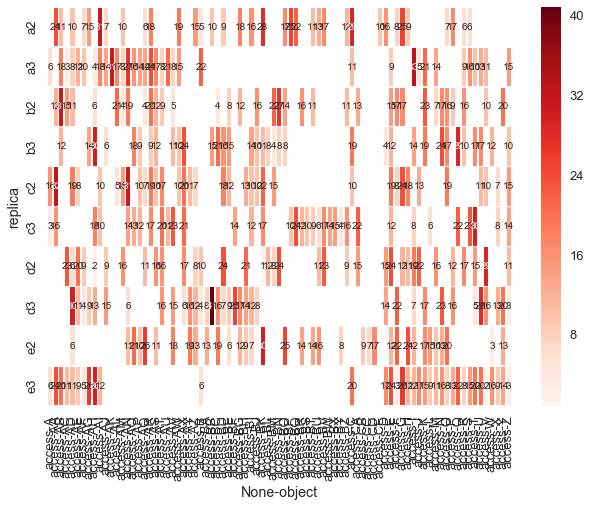

In [3]:
@interact(u=(1,20), l=(1,5), o=(1, 70), Pc=(0.0, 1.0, 0.05), 
         t=(1000, 1000000), Am=(10, 2000), As=(1, 1000), 
          Pr=(0.0, 1.0, 0.05), Po=(0.0, 1.0, 0.05), __manual=True)
def create_workload(u, l, o, Pc, t, Am, As, Pr, Po):
    # Reset the object space
    ConflictWorkloadAllocation.object_factory.reset()
    
    # Intantiate the workload
    workload = ConflictWorkloadAllocation(
        simulation, n_objects=o, conflict_prob=Pc, loc_max_users=l, 
        object_prob=Po, read_prof=Pr, access_mean=Am, access_stddev=As,
    )
    
    # Allocate work to n users and get ready to generate work 
    workload.allocate_many(n_users=u)
    writer = TracesWriter(workload, timesteps=t)

    # Run the workload and write the traces 
    traces = StringIO()
    writer.write(traces)
    traces.seek(0)
    
    # Create a dataframe from the traces and analyze 
    df = pd.read_csv(traces, sep='\t', names=('timestep', 'replica', 'object', 'access'))
    replicas = df.groupby(['replica', 'object']).agg({'access': 'count'})
    replicas = pd.DataFrame(replicas.to_records()).pivot('replica', 'object')
    
    # Visualize the results of the workload 
    sns.heatmap(replicas, annot=True, fmt="0.0f", linewidths=.5, cmap="Reds")

## Partitions

Partitions are passed to the simulation via a TSV file called "outages", which is generated via the following parameters:

- a topology, which defines the set of replicas, $R$, and their locations, $L$ 
- connection type to cut: choice of `wide`, `local`, or `both`. 
- $d_\mu$, $d_\sigma$: define a normal distribution of outage duration 
- $o_\mu$, $o_\sigma$: deinfe a normal distribution of online duration 
- $p_d$: probability of an outage  
- $t$: total amount of time (milliseconds) in the simulation 

The topology specifies a set of replica servers (replicas), e.g. devices on the network, and their connections, which determine the latency of passing a message between two devices. Each replica is assigned to a single location; a connection between two replicas in the same location is considered a `local` connection, while a connection between replicas in two different locations is `wide` (wide area). Latencies are specified in the topology, but generally a connection over a wide area should have poorer performance than local connections. 

Outages are then generated on a _per-connection_ basis, selecting the connections as defined by the connection types. Currently I'm only cutting wide area links rather than local or both. Starting with timestep 0, the probability of an outage, $p_d$ is used to determine if the next period is _online_ or _outage_. Then the normal distribution parameters for that state are used to determine the duration of the period. This sequence continues until the timestep is greater than or equal to $t$. 

**Note**: In order to replicate the Raft "time without a leader" graph, there is a special simulation configuration where only the leader is partitioned. This is not passed to the simulation as an outage file (since the leader is determined at runtime). 

### Variable Latency 

A twist on the partition scheme is instead of causing outages, to vary the latency parameters of the connection. A connection can have one of the following latency definitions:

- constant: message time is always the same, $\lambda$ milliseconds 
- variable: uniform random latency in a range, $\lambda \in [\lambda_l, \lambda_h]$
- normal: normally distributed latencies defined by $\lambda_\mu$ and $\lambda_\sigma$

In order to vary latency, we use the following additional parameters:

- $\delta_\mu$ and $\delta_\sigma$ define the normally distributed absolute value of change 
- $p_i$ the probability of an increases in latency, the probability of a decrease, $p_d = 1-p_i$ 

Now at every "outage", rather than simply setting a flag on the connection that indicates messages can't be sent, we adapt the latency definition instead as follows. First, select a $\delta_\lambda$ via the normal distrbution of change then determine whether to multiply it by -1 via $p_i$. This is then added to $\lambda$, $\lambda_l$, $\lambda_h$, or $\lambda_\mu$, depending what is present on the connection. The old values are saved and restored when the outage duration is complete. 

**TODO**: We still have no mechanism to vary the $\lambda_\sigma$ of a network connection. 

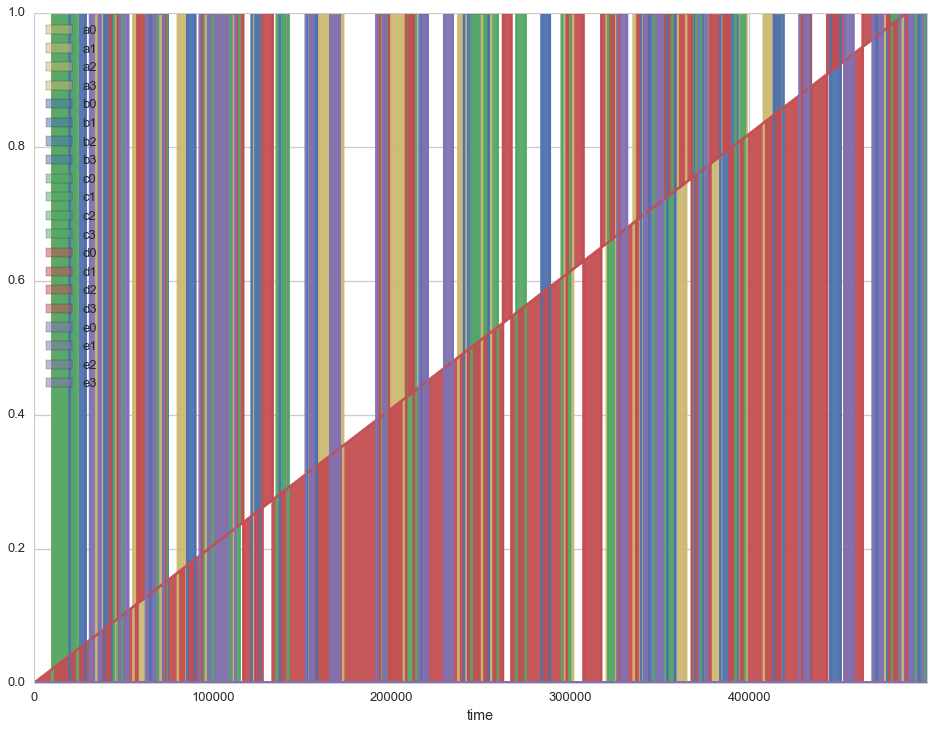

In [18]:
from collections import defaultdict 
from cloudscope.simulation.outages import Outages, OutagesWriter, PARTITION_TYPES

@interact(strategy=PARTITION_TYPES, Dm=(100,10000, 100), Ds=(10, 1000), Om=(200,20000, 100), Os=(10,1000), Pd=(0.0, 1.0, 0.05), t=(1000, 1000000), __manual=True)
def create_outages(strategy, Dm, Ds, Om, Os, Pd, t):
    
    # Create the outages generators 
    outages = Outages(
        simulation, partition_across=strategy, 
        outage_mean=Dm, outage_stddev=Ds, 
        online_mean=Om, online_stddev=Os, 
        outage_prob=Pd
    )
    
    # Create the writer to serialize outages 
    writer = OutagesWriter(outages, timesteps=t)
    
    # Run the workload and write the traces 
    traces = StringIO()
    writer.write(traces)
    traces.seek(0)
    
    # Create a dataframe from the traces and analyze 
    data = defaultdict(lambda: [[0, 0, 0]])
    for line in traces:
        line  = line.split()
        time  = int(line[0])
        state = 1 if line[1] == 'offline' else 0
        src   = line[2]
        dst   = line[3]
        
        if len(data[src]) > 0:
            prev  = data[src][-1]
            if prev[0] == time:
                prev[1] += 1 
                continue 
            
            if prev[2] != state:
                data[src].append([time-1, prev[1], prev[2]])
        
        data[src].append([time, 1, state])
    
    data = pd.DataFrame([
            {replica: value[2], 'time': value[0]}
            for replica, values in data.items()
            for value in values 
        ])
    
    idx    = 0 
    cmap   = {}
    colors = {}
    for col in data.columns:
        if col == 'time': continue 
        if col[0] not in cmap:
            cmap[col[0]] = sns.color_palette()[idx]
            idx += 1 
        colors[col] = cmap[col[0]]
    
    data.plot.area(x='time', stacked=False, figsize=(16,12), colors=colors.values())